In [4]:
pip install numpy folium matplotlib


Total jarak (fitness terbaik): 337.32
Truk 1: [2, 28, 36, 5, 0]
Truk 2: [13, 29, 49, 35, 6]
Truk 3: [1, 43, 37, 40, 46]
Truk 4: [48, 24, 31, 44, 47]
Truk 5: [20, 22, 45, 21, 3]
Truk 6: [23, 30, 9, 14, 38]
Truk 7: [4, 33, 34, 16, 12]
Truk 8: [15, 10, 39, 32, 8]
Truk 9: [11, 42, 41, 18, 7]
Truk 10: [19, 17, 26, 25, 27]


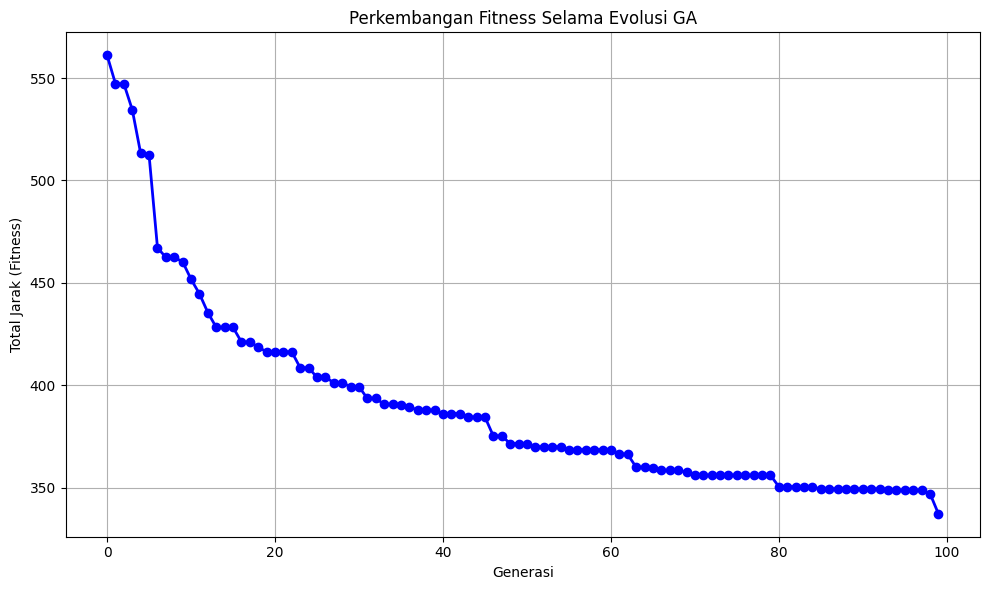

In [5]:
import random
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import folium
import matplotlib.pyplot as plt

# === Konfigurasi Dasar ===
N_LOKASI = 50
N_TRUK = 10
POP_SIZE = 100
GEN = 100
DEPOT = [-6.2, 106.8]  # Titik awal depot truk

# === Generate Koordinat Lokasi Secara Acak (Jabodetabek) ===
np.random.seed(42)
lokasi_koordinat = np.random.uniform(low=[-6.3, 106.7], high=[-6.1, 106.9], size=(N_LOKASI, 2))

# === Fungsi Haversine untuk Menghitung Jarak antar Koordinat ===
def haversine(coord1, coord2):
    R = 6371  # Radius bumi dalam km
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# === Matriks Jarak antar Lokasi ===
distance_matrix = np.zeros((N_LOKASI, N_LOKASI))
for i in range(N_LOKASI):
    for j in range(N_LOKASI):
        if i != j:
            distance_matrix[i][j] = haversine(lokasi_koordinat[i], lokasi_koordinat[j])

# === Genetic Algorithm Functions ===
def generate_chromosome():
    locs = list(range(N_LOKASI))
    random.shuffle(locs)
    return locs

def split_routes(chromo):
    avg = len(chromo) // N_TRUK
    return [chromo[i*avg:(i+1)*avg] for i in range(N_TRUK)]

def route_distance(route):
    if not route:
        return 0
    dist = haversine(DEPOT, lokasi_koordinat[route[0]])
    for i in range(len(route)-1):
        dist += distance_matrix[route[i]][route[i+1]]
    dist += haversine(lokasi_koordinat[route[-1]], DEPOT)
    return dist

def fitness(chromo):
    routes = split_routes(chromo)
    return sum(route_distance(r) for r in routes)

# === Inisialisasi Populasi dan Jalankan Evolusi ===
population = [generate_chromosome() for _ in range(POP_SIZE)]
best_fitness_per_gen = []

for gen in range(GEN):
    scores = [(fitness(chromo), chromo) for chromo in population]
    scores.sort()
    best = scores[0]
    best_fitness_per_gen.append(best[0])

    new_population = [best[1]]
    while len(new_population) < POP_SIZE:
        p1 = random.choice(scores[:20])[1]
        p2 = random.choice(scores[:20])[1]
        cut = random.randint(1, N_LOKASI-2)
        child = p1[:cut] + [g for g in p2 if g not in p1[:cut]]
        if random.random() < 0.1:
            i, j = random.sample(range(N_LOKASI), 2)
            child[i], child[j] = child[j], child[i]
        new_population.append(child)
    population = new_population

# === Ambil Solusi Terbaik ===
best_fitness = best_fitness_per_gen[-1]
best_solution = scores[0][1]
best_routes = split_routes(best_solution)

print("Total jarak (fitness terbaik):", round(best_fitness, 2))
for i, r in enumerate(best_routes):
    print(f"Truk {i+1}: {r}")

# === Visualisasi Rute di Peta HTML ===
m = folium.Map(location=DEPOT, zoom_start=11)
folium.Marker(location=DEPOT, popup="Depot", icon=folium.Icon(color='red')).add_to(m)

colors = [
    'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'darkgreen',
    'pink', 'lightgray', 'black'
]

for i, route in enumerate(best_routes):
    color = colors[i % len(colors)]
    points = [DEPOT] + [lokasi_koordinat[loc].tolist() for loc in route] + [DEPOT]
    folium.PolyLine(points, color=color, weight=3, opacity=0.7, tooltip=f"Truk {i+1}").add_to(m)
    for loc in route:
        folium.Marker(
            location=lokasi_koordinat[loc].tolist(),
            popup=f"Lokasi {loc}",
            icon=folium.Icon(color=color)
        ).add_to(m)

m.save("rute_truk_logistik.html")

# === Visualisasi Grafik Fitness ===
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_per_gen, marker='o', color='blue', linewidth=2)
plt.title("Perkembangan Fitness Selama Evolusi GA")
plt.xlabel("Generasi")
plt.ylabel("Total Jarak (Fitness)")
plt.grid(True)
plt.tight_layout()
plt.savefig("simulasi_fitness_ga.png")
plt.show()
